In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

In [246]:
df = pd.read_csv('product_usage_data.csv')
df.head()

,timestamp,day,day_scaler,disruptor,insert_scaler,daily_active_users
0,1/1/2024,1,1.00,NaN,100,1114
1,1/2/2024,2,1.10,NaN,110,1129
2,1/3/2024,3,1.25,NaN,125,1134
3,1/4/2024,4,1.30,NaN,130,1137
4,1/5/2024,5,1.25,NaN,125,1131


In [247]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [248]:
df.head()

,timestamp,day,day_scaler,disruptor,insert_scaler,daily_active_users
0,2024-01-01,1,1.00,NaN,100,1114
1,2024-01-02,2,1.10,NaN,110,1129
2,2024-01-03,3,1.25,NaN,125,1134
3,2024-01-04,4,1.30,NaN,130,1137
4,2024-01-05,5,1.25,NaN,125,1131


In [249]:
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])

<Axes: xlabel='timestamp'>

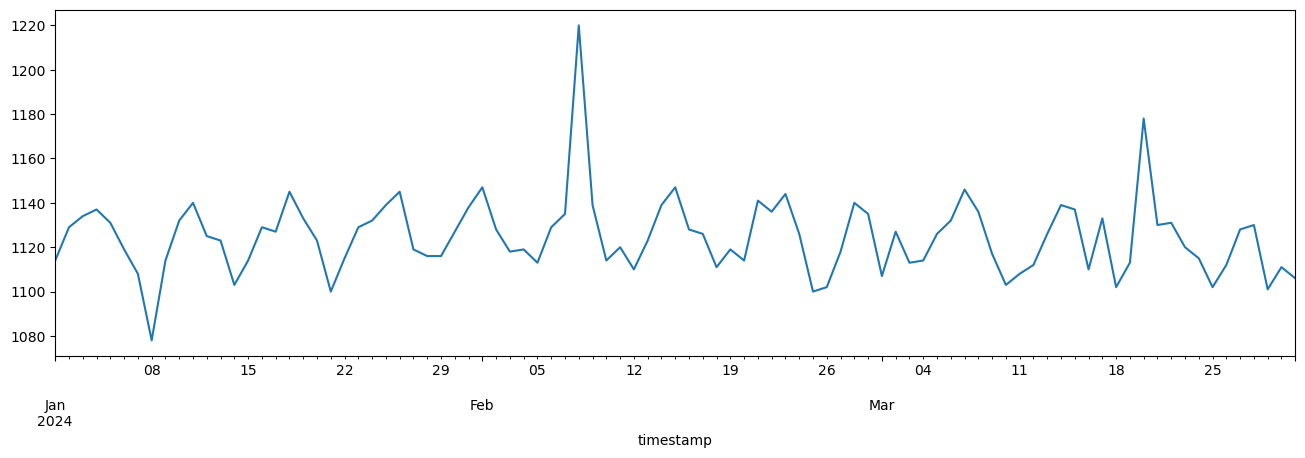

In [250]:
dau.plot(figsize=(16,4.5))

In [251]:
dau.describe()

count      91.000000
mean     1124.615385
std        17.728050
min      1078.000000
25%      1114.000000
50%      1126.000000
75%      1133.500000
max      1220.000000
dtype: float64

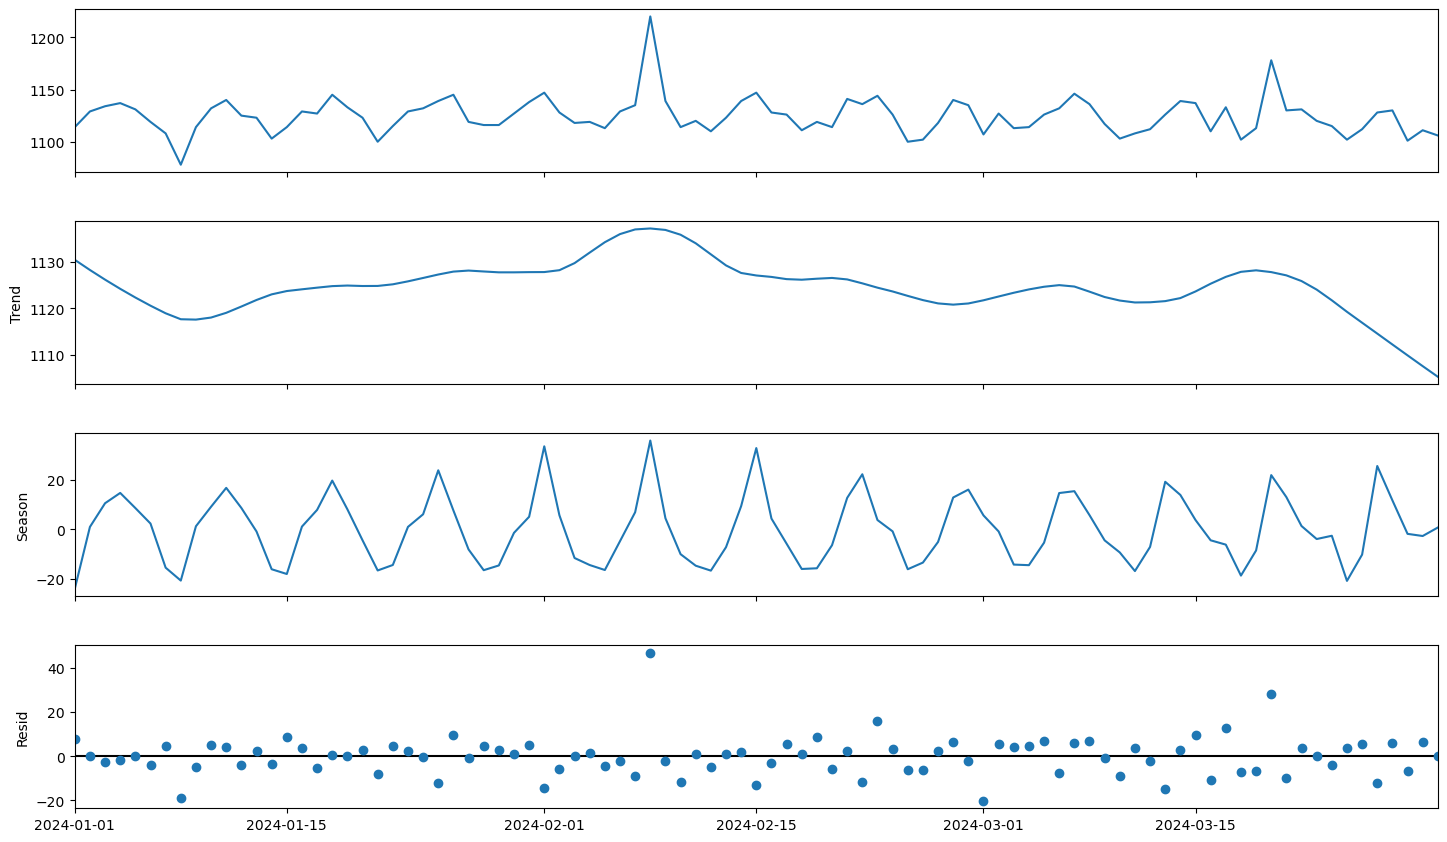

In [252]:
stl = STL(dau, period=7)
res = stl.fit()

# Calculate mean and standard deviation of residuals
mean_resid = np.mean(res.resid)
std_resid = np.std(res.resid)

# Identify anomalies
z_scores = np.abs((res.resid - mean_resid) / std_resid)
anomalies = z_scores > 1.96

# Plot residuals
fig = res.plot()
fig.set_size_inches((16, 9))

<Axes: title={'center': 'Residuals'}, xlabel='timestamp'>

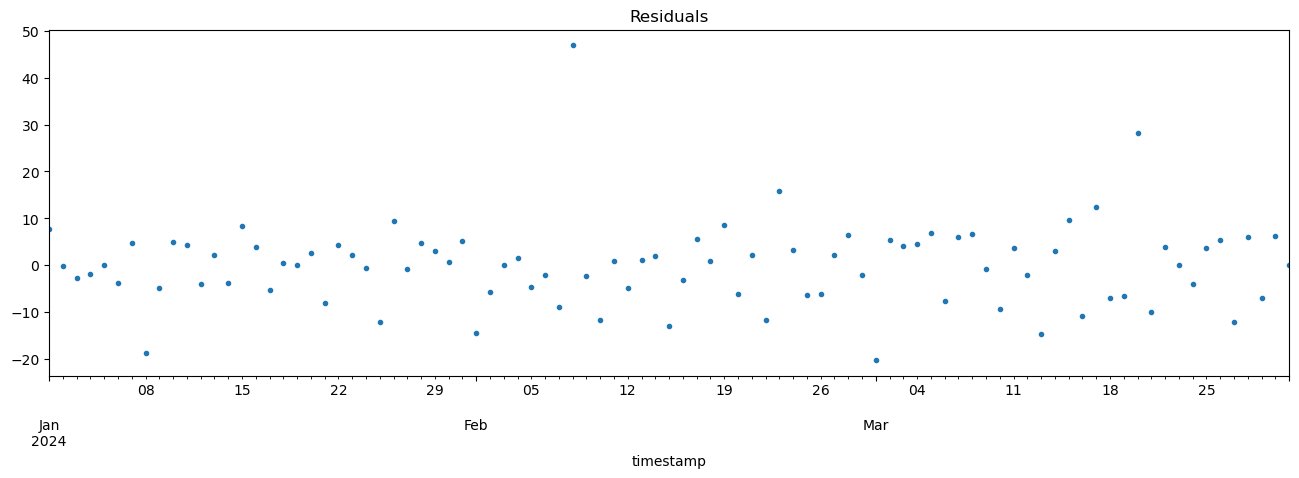

In [253]:
res.resid.plot(marker='.', linestyle='none', figsize=(16,4.5), title='Residuals')

In [257]:
trend_iv_l_minor = pd.Series(data=res.trend.values-np.mean(res.trend)-np.std(res.resid), index=res.trend.index)
trend_iv_u_minor = pd.Series(data=res.trend.values-np.mean(res.trend)+np.std(res.resid), index=res.trend.index)\

trend_iv_l_major = pd.Series(data=res.trend.values-np.mean(res.trend)-2*np.std(res.resid), index=res.trend.index)
trend_iv_u_major = pd.Series(data=res.trend.values-np.mean(res.trend)+2*np.std(res.resid), index=res.trend.index)

trend_iv_l_severe = pd.Series(data=res.trend.values-np.mean(res.trend)-3*np.std(res.resid), index=res.trend.index)
trend_iv_u_severe = pd.Series(data=res.trend.values-np.mean(res.trend)+3*np.std(res.resid), index=res.trend.index)

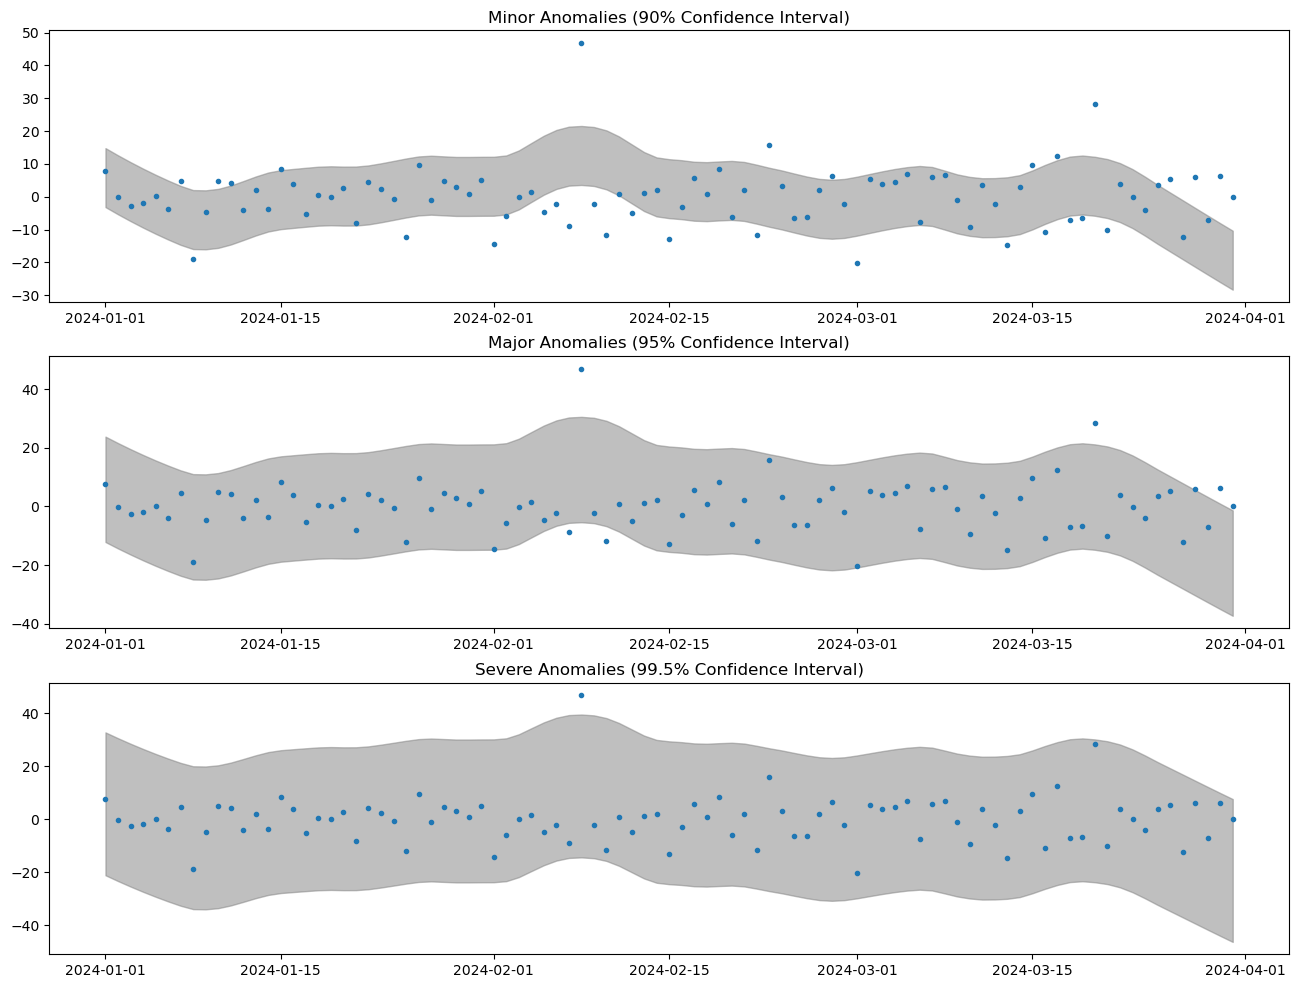

In [262]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))
ax1.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax1.set_title('Minor Anomalies (90% Confidence Interval)')
ax1.fill_between(res.resid.index, trend_iv_l_minor, trend_iv_u_minor, color='grey', alpha=0.5, label='confidence interval')

ax2.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax2.set_title('Major Anomalies (95% Confidence Interval)')
ax2.fill_between(res.resid.index, trend_iv_l_major, trend_iv_u_major, color='grey', alpha=0.5, label='confidence interval')

ax3.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax3.set_title('Severe Anomalies (99.5% Confidence Interval)')
ax3.fill_between(res.resid.index, trend_iv_l_severe, trend_iv_u_severe, color='grey', alpha=0.5, label='confidence interval')

In [274]:
minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, 0)
major_anom = np.where((res.resid < trend_iv_l_major) | (res.resid > trend_iv_u_major), res.resid, 0)
severe_anom = np.where((res.resid < trend_iv_l_severe) | (res.resid > trend_iv_u_severe), res.resid, 0)


In [ ]:
ax1.plot(pd.Series(), marker='.', linestyle='none', label='Anomalies')

ax2.plot(res.resid, marker='.', linestyle='none', label='Anomalies')

ax3.plot(res.resid, marker='.', linestyle='none', label='Anomalies')